In [9]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go # 그래프 객체 생성
from plotly.subplots import make_subplots
import datetime
import seaborn as sns 
import scipy.stats
import plotly.express as px
import os 
from scipy import stats
from sklearn import metrics
import statsmodels.formula.api as smf
import scipy.stats as st
import pylab
import csv

os.getcwd()

data1 = pd.read_csv("./ENITT_SOLAR_DATA/ENITT_SOLAR_DATA/A798. 육아종합지원센터 발전량.csv", encoding="ms949")
data2 = pd.read_csv("./ENITT_SOLAR_DATA/ENITT_SOLAR_DATA/A798. 육아종합지원센터 환경센서.csv", encoding="ms949")



ent_data_solar = data1.reset_index().drop('index', axis=1)
ent_data_solar

ent_data_weather = data2.reset_index().drop('index', axis=1)


## 외부데이터 불러오기 
other_data_weather = pd.read_csv("./ENITT_SOLAR_DATA/otherdata/원주.csv", encoding="ms949")
other_data_weather = other_data_weather[other_data_weather["지점명"] == "원주"]
other_data_weather["지점명"].unique()



# print()
ent_data_solar1 = ent_data_solar[ent_data_solar["pow_id"] == 1]
# ent_data_weather

other_data_weather
ent_data_solar1["pow_id"].unique()


array([1], dtype=int64)

In [10]:
## DELETE COLUMN AND EDIT COLUMN

## '지점', '지점명', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)','일조(hr)', '일사(MJ/m2)', '적설(cm)', '전운량(10분위)', '10cm 지중온도(°C)'
#=>

## '기온', '강수량', '풍속', '풍향', '습도', '일조', '일사', '전운량', '지면온도'
reset_other_weather = other_data_weather.set_index("일시")
reset_other_weather_need = reset_other_weather[['일사(MJ/m2)']]
reset_other_weather_need.columns = ['일사']
reset_other_weather_need.fillna(0, inplace=True)
reset_other_weather_need


## 기업 solar weather EDA -> 필요
ent_data_weather.columns 

ent_data_weather["env_levelsolar"].describe()
ent_data_weather["env_slopesolar"].describe()


## 기업 날씨 데이터 1시간 별로 groupby , ( slopesolar, levelsolar => sum) , ( modtemp, airtemp => mean )
def groupby_weather():
    ## time 구분
    dummy_time_list = []
    for i in ent_data_weather["env_time"]:
        dummy_time_list.append(i[:2])

    ent_data_weather["dummy_time"] = dummy_time_list
    dummy_groupbyall = ent_data_weather.groupby(["env_date", "dummy_time"]).mean()
    ent_data_weather_groupby = dummy_groupbyall.reset_index() ## 그룹화된 인덱스 풀기 

    ### 발전량이 거의 없는 데이터 삭제 ( 9~ 19 까지만 살린다)
    drop_data = ent_data_weather_groupby.isin({"dummy_time" : ["00", "01", "02", "03", "04", "05", "06", "07","08","18", "19", "20", "21", "22", "23"]})
    ent_data_weather_sort = ent_data_weather_groupby[~drop_data].dropna()
    # print(ent_data_weather_sort)
    ent_data_weather_sort.drop("env_index", axis=1, inplace=True)

    return ent_data_weather_sort




def groupby_solar_reset():
    ## 필요한 컬럼만 가져오기
    ent_data_need = ent_data_solar1[["pow_date", "pow_time", "pow_dcv", "pow_dca"]]

    ## time 구분
    dummy_time_list = []
    for i in ent_data_need["pow_time"]:
        dummy_time_list.append(i[:2])
    ent_data_need["dummy_time"] = dummy_time_list

    ent_data_need["watt"] = ent_data_need["pow_dcv"] * ent_data_need["pow_dca"]

    ## RESET 발전량 :: 직류 전압 X 직류 전류 : 발전량 ,, GROUPBY해서 직류X전류 의 평균량으로 구한다
    ent_data_perhour = ent_data_need.groupby(["pow_date", "dummy_time"]).mean()
    ent_data_perhour = ent_data_perhour.reset_index()


    drop_data = ent_data_perhour.isin({"dummy_time" : ["00", "01", "02", "03", "04", "05", "06", "07","08","18", "19", "20", "21", "22", "23"]})
    ent_data_perhour_sort = ent_data_perhour[~drop_data].dropna()

    return ent_data_perhour_sort

### weather, solar join
def join_weather_solar(a, b):
    sub_index1 = a["env_date"] + " " + a["dummy_time"] + ":00"
    a.index = sub_index1

    sub_index2 = b["pow_date"] + " " + b["dummy_time"] + ":00"
    b.index = sub_index2

    joinset = a.join(b[["pow_dcv", "pow_dca", "watt" ]])
    ent_data_solar_weather = joinset.dropna()


    return ent_data_solar_weather

ent_data_weather_sort = groupby_weather()
ent_data_perhour_sort = groupby_solar_reset()
ent_data_solar_weather = join_weather_solar(ent_data_weather_sort, ent_data_perhour_sort)
ent_data_solar_weather



,env_date,dummy_time,env_slopesolar,env_levelsolar,env_modtemp,env_airtemp,pow_dcv,pow_dca,watt
2020-04-08 09:00,2020-04-08,09,489.342857,558.500000,18.911429,10.327143,565.314286,28.081429,15869.564286
2020-04-08 10:00,2020-04-08,10,690.071429,705.200000,20.910000,11.652857,554.657143,39.344286,21810.225714
2020-04-08 11:00,2020-04-08,11,850.366197,803.873239,22.083099,12.515493,548.859155,47.905634,26292.469014
2020-04-08 12:00,2020-04-08,12,941.928571,834.428571,23.654286,13.428571,539.357143,52.568571,28351.118571
2020-04-08 13:00,2020-04-08,13,952.685714,798.500000,26.934286,14.252857,532.414286,53.115714,28279.470000
...,...,...,...,...,...,...,...,...,...
2020-10-22 13:00,2020-10-22,13,143.000000,145.750000,19.325000,17.091667,543.416667,8.308333,4526.508333
2020-10-22 14:00,2020-10-22,14,201.692308,194.923077,22.869231,18.261538,539.769231,11.284615,6132.900000
2020-10-22 15:00,2020-10-22,15,112.416667,100.250000,19.366667,17.725000,533.250000,6.333333,3410.966667
2020-10-22 16:00,2020-10-22,16,185.916667,136.000000,22.233333,17.366667,533.833333,9.700000,5215.566667


In [11]:
## 기업, 공공 join

join_ent_other = ent_data_solar_weather.join(reset_other_weather_need)
join_ent_other["일사"].fillna(0, inplace=True)
# join_ent_other
join_ent_other["match_solar"] = join_ent_other["일사"] * 1000000 / 3600
join_ent_other_set = join_ent_other.drop(["env_date", "dummy_time"], axis=1)





2.2565286784551906
-1.658916329687787


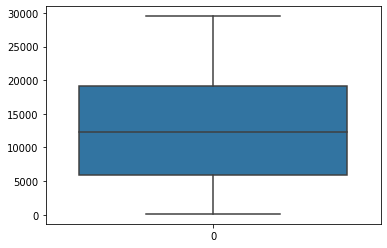

In [12]:
## 이상치 제거

# sns.boxplot(data = join_ent_other_set["watt"])


import pandas as pd
from scipy import stats

# deleteoutlier = stats.zscore(join_ent_other_set["watt"])
# deleteoutlier
deleteoutlier = stats.zscore(join_ent_other_set["watt"])
join_ent_other_set["z_score"] = deleteoutlier

join_ent_other_del = join_ent_other_set.loc[join_ent_other_set['z_score'].abs()<=3]
join_ent_other_del.describe()
sns.boxplot(data = join_ent_other_del["watt"])
# df.loc[df['z_score'].abs()<=3]
print(join_ent_other_del['z_score'].max())
print(join_ent_other_del['z_score'].min())
## csv 저장
join_ent_other_del.to_csv('yuka_join.csv', encoding='utf-8')

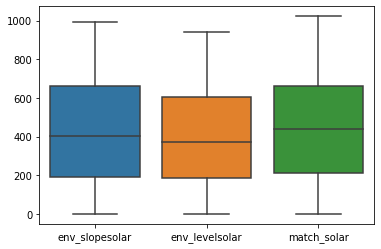

In [13]:
sns.boxplot(data = join_ent_other_del[["env_slopesolar", "env_levelsolar", "match_solar"]])